In [1]:
import sys

sys.path.append("..")

%load_ext autoreload
%autoreload complete

In [2]:
from math import ceil
from pathlib import Path

import dask.array
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr

from project.plotting import plot_field, format_plot, save_plot
from project.util import stack_state, unstack_state
from project.spaces import PhysicalSpaceForecastSpaceMapper
from project.lim import LIM
from project.io import save_mfdataset

In [3]:
data = xr.open_mfdataset(
    # Path("/home/enkf6/dstiller/enspred/training_data/2023-12-03T15-00-42/").glob("**/*.nc")  # monthly
    Path("/home/enkf6/dstiller/enspred/training_data/2023-12-08T00-14-44/").glob("**/*.nc")  # annual
)["data"]
data

<xarray.DataArray 'data' (state: 50, time: 1849)>
dask.array<concatenate, shape=(50, 1849), dtype=float64, chunksize=(50, 100), chunktype=numpy.ndarray>
Coordinates:
  * state    (state) int64 0 1 2 3 4 5 6 7 8 9 ... 40 41 42 43 44 45 46 47 48 49
  * time     (time) int64 7001 7002 7003 7004 7005 ... 8845 8846 8847 8848 8849

In [4]:
mapper = PhysicalSpaceForecastSpaceMapper.load(
    # Path("/home/enkf6/dstiller/enspred/mapper/mapper-2023-12-03T14-51-55.pkl")  # monthly
    Path("/home/enkf6/dstiller/enspred/mapper/mapper-2023-12-08T00-12-39.pkl")  # annual
)

In [5]:
lim = LIM()
taus = lim.fit(data)#.isel(time=slice(1000)))
lim.save(Path("/home/enkf6/dstiller/enspred/lim"))

2023-12-07 23:41:22    INFO Saving LIM to /home/enkf6/dstiller/enspred/lim/lim-2023-12-07T23-41-22.pkl


In [6]:
#lim = LIM.load(Path("/home/enkf6/dstiller/enspred/lim/lim-2023-12-06T19-20-57.pkl"))

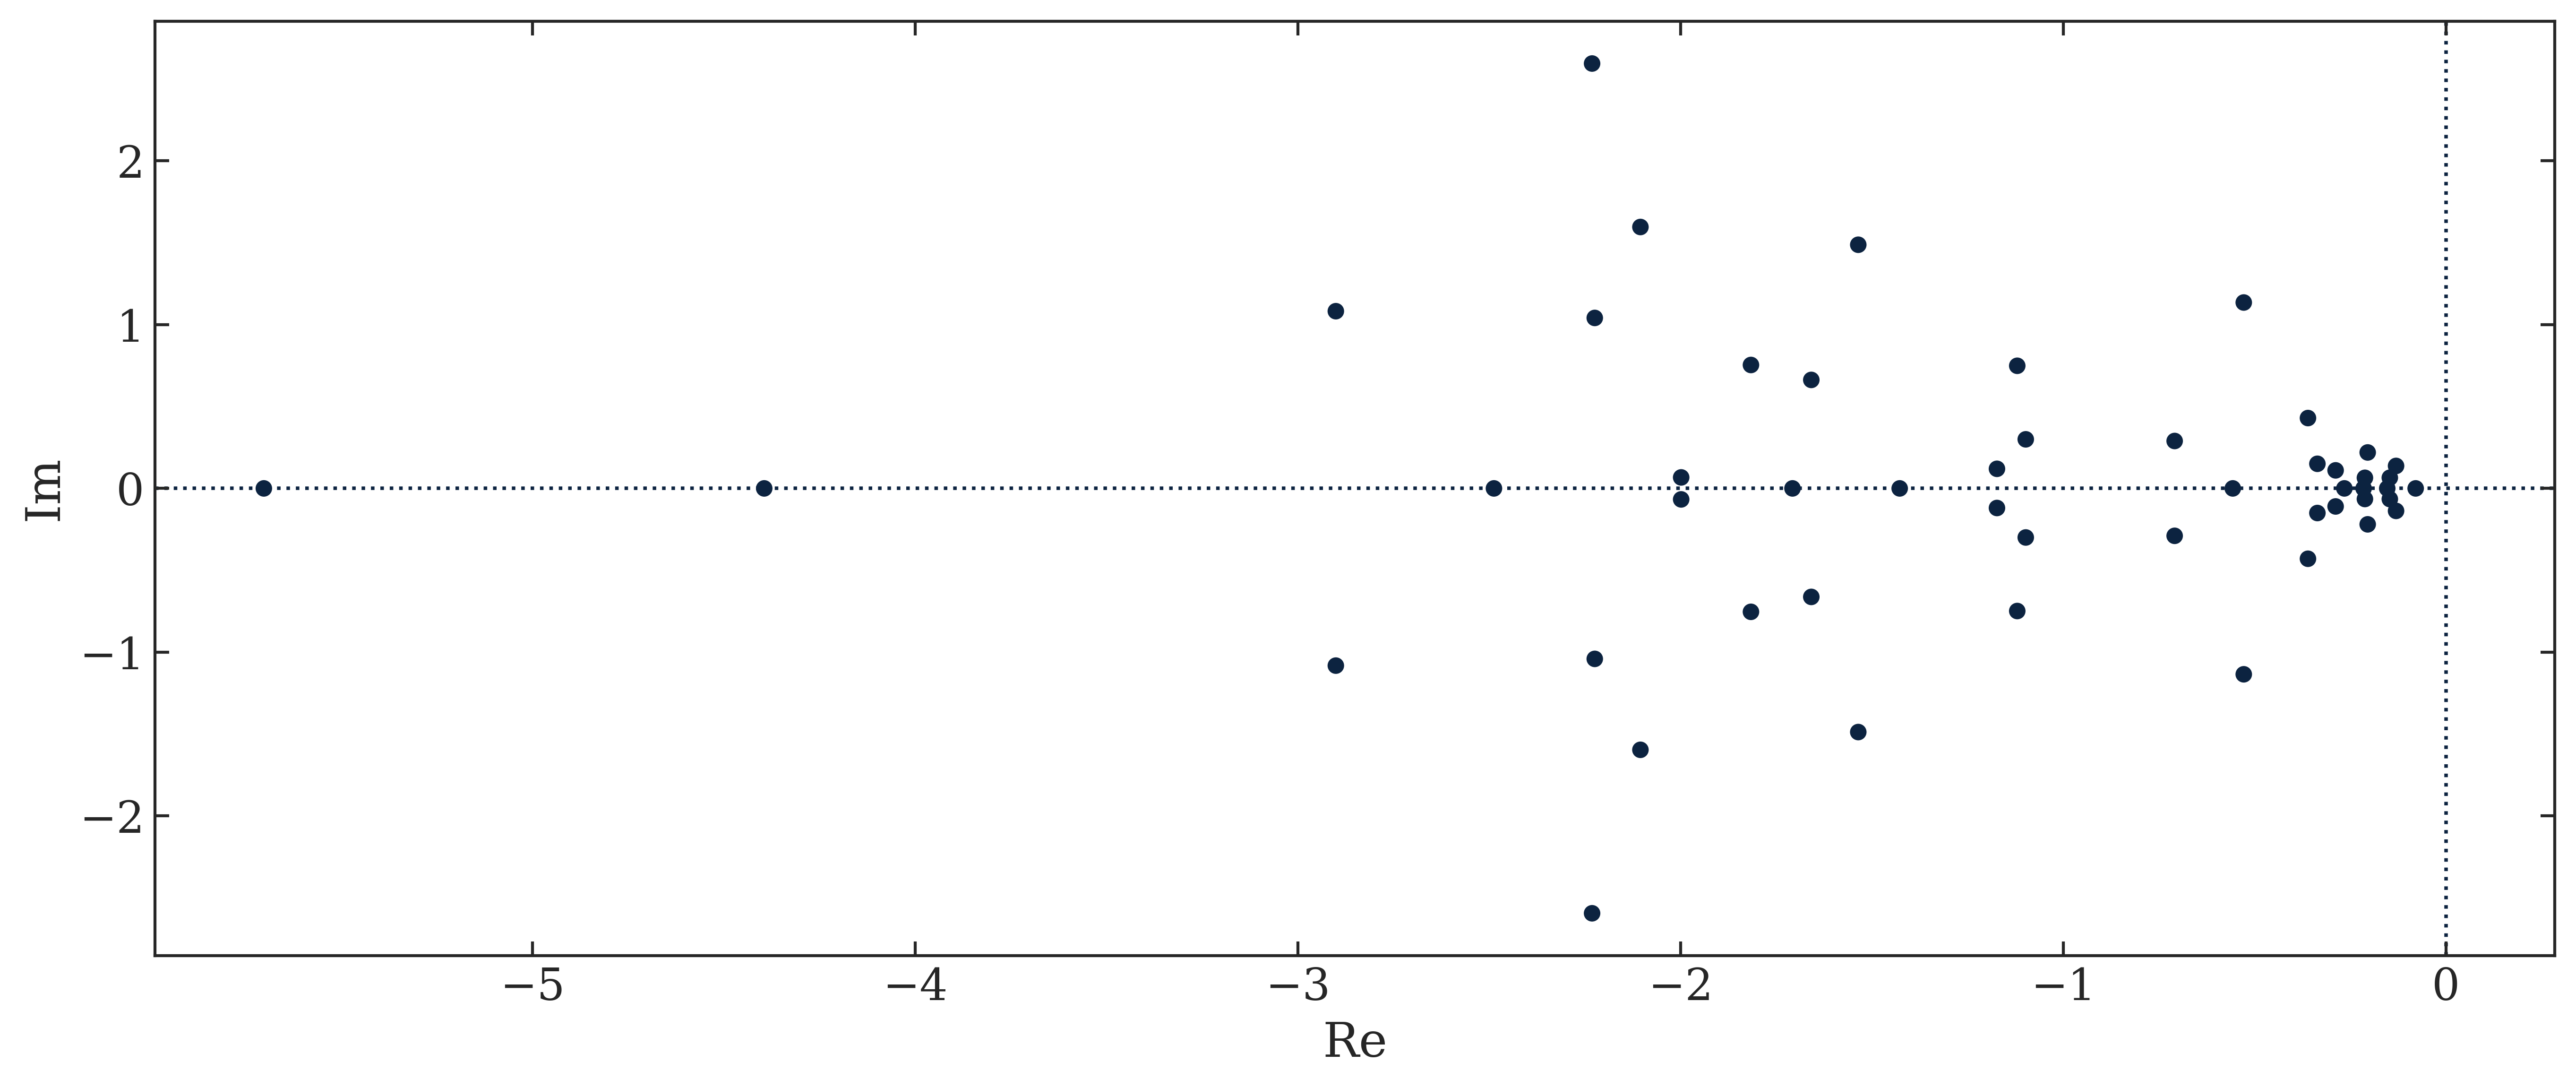

In [7]:
def plot_eigenvalues():
    fig, ax = plt.subplots()

    eigs = np.linalg.eigvals(lim.L)
    ax.axvline(0, ls=":")
    ax.axhline(0, ls=":")
    ax.scatter(np.real(eigs), np.imag(eigs), c=np.where(np.real(eigs) < 0, "C0", "C1"))
    ax.set_xlabel("Re")
    ax.set_ylabel("Im")

    format_plot()

plot_eigenvalues()

In [13]:
def plot_frequency_spectrum():
    fig, ax = plt.subplots()

    eigs = np.linalg.eigvals(lim.L)
    eigs = eigs[np.imag(eigs) >= 0]
    fs = 2 * np.pi * np.sqrt(np.imag(eigs))

    ax.scatter(fs, -np.real(eigs))
    ax.set_xlabel("Frequency [1/month]")
    ax.set_ylabel("Time constant (higher = faster)")
    # ax.set_xlim([0.01, ax.get_xlim()[1]])
    ax.axvline(1/12)
    ax.axvline(1)
    # ax.set_xscale("log")

    secax = ax.secondary_xaxis("top", functions=(lambda x: 1/x, lambda x: 1/x))
    secax.set_xlabel("Period [month]")
    secax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(12))

    format_plot()

# plot_frequency_spectrum()

100%|██████████| 20/20 [00:00<00:00, 14841.84it/s]


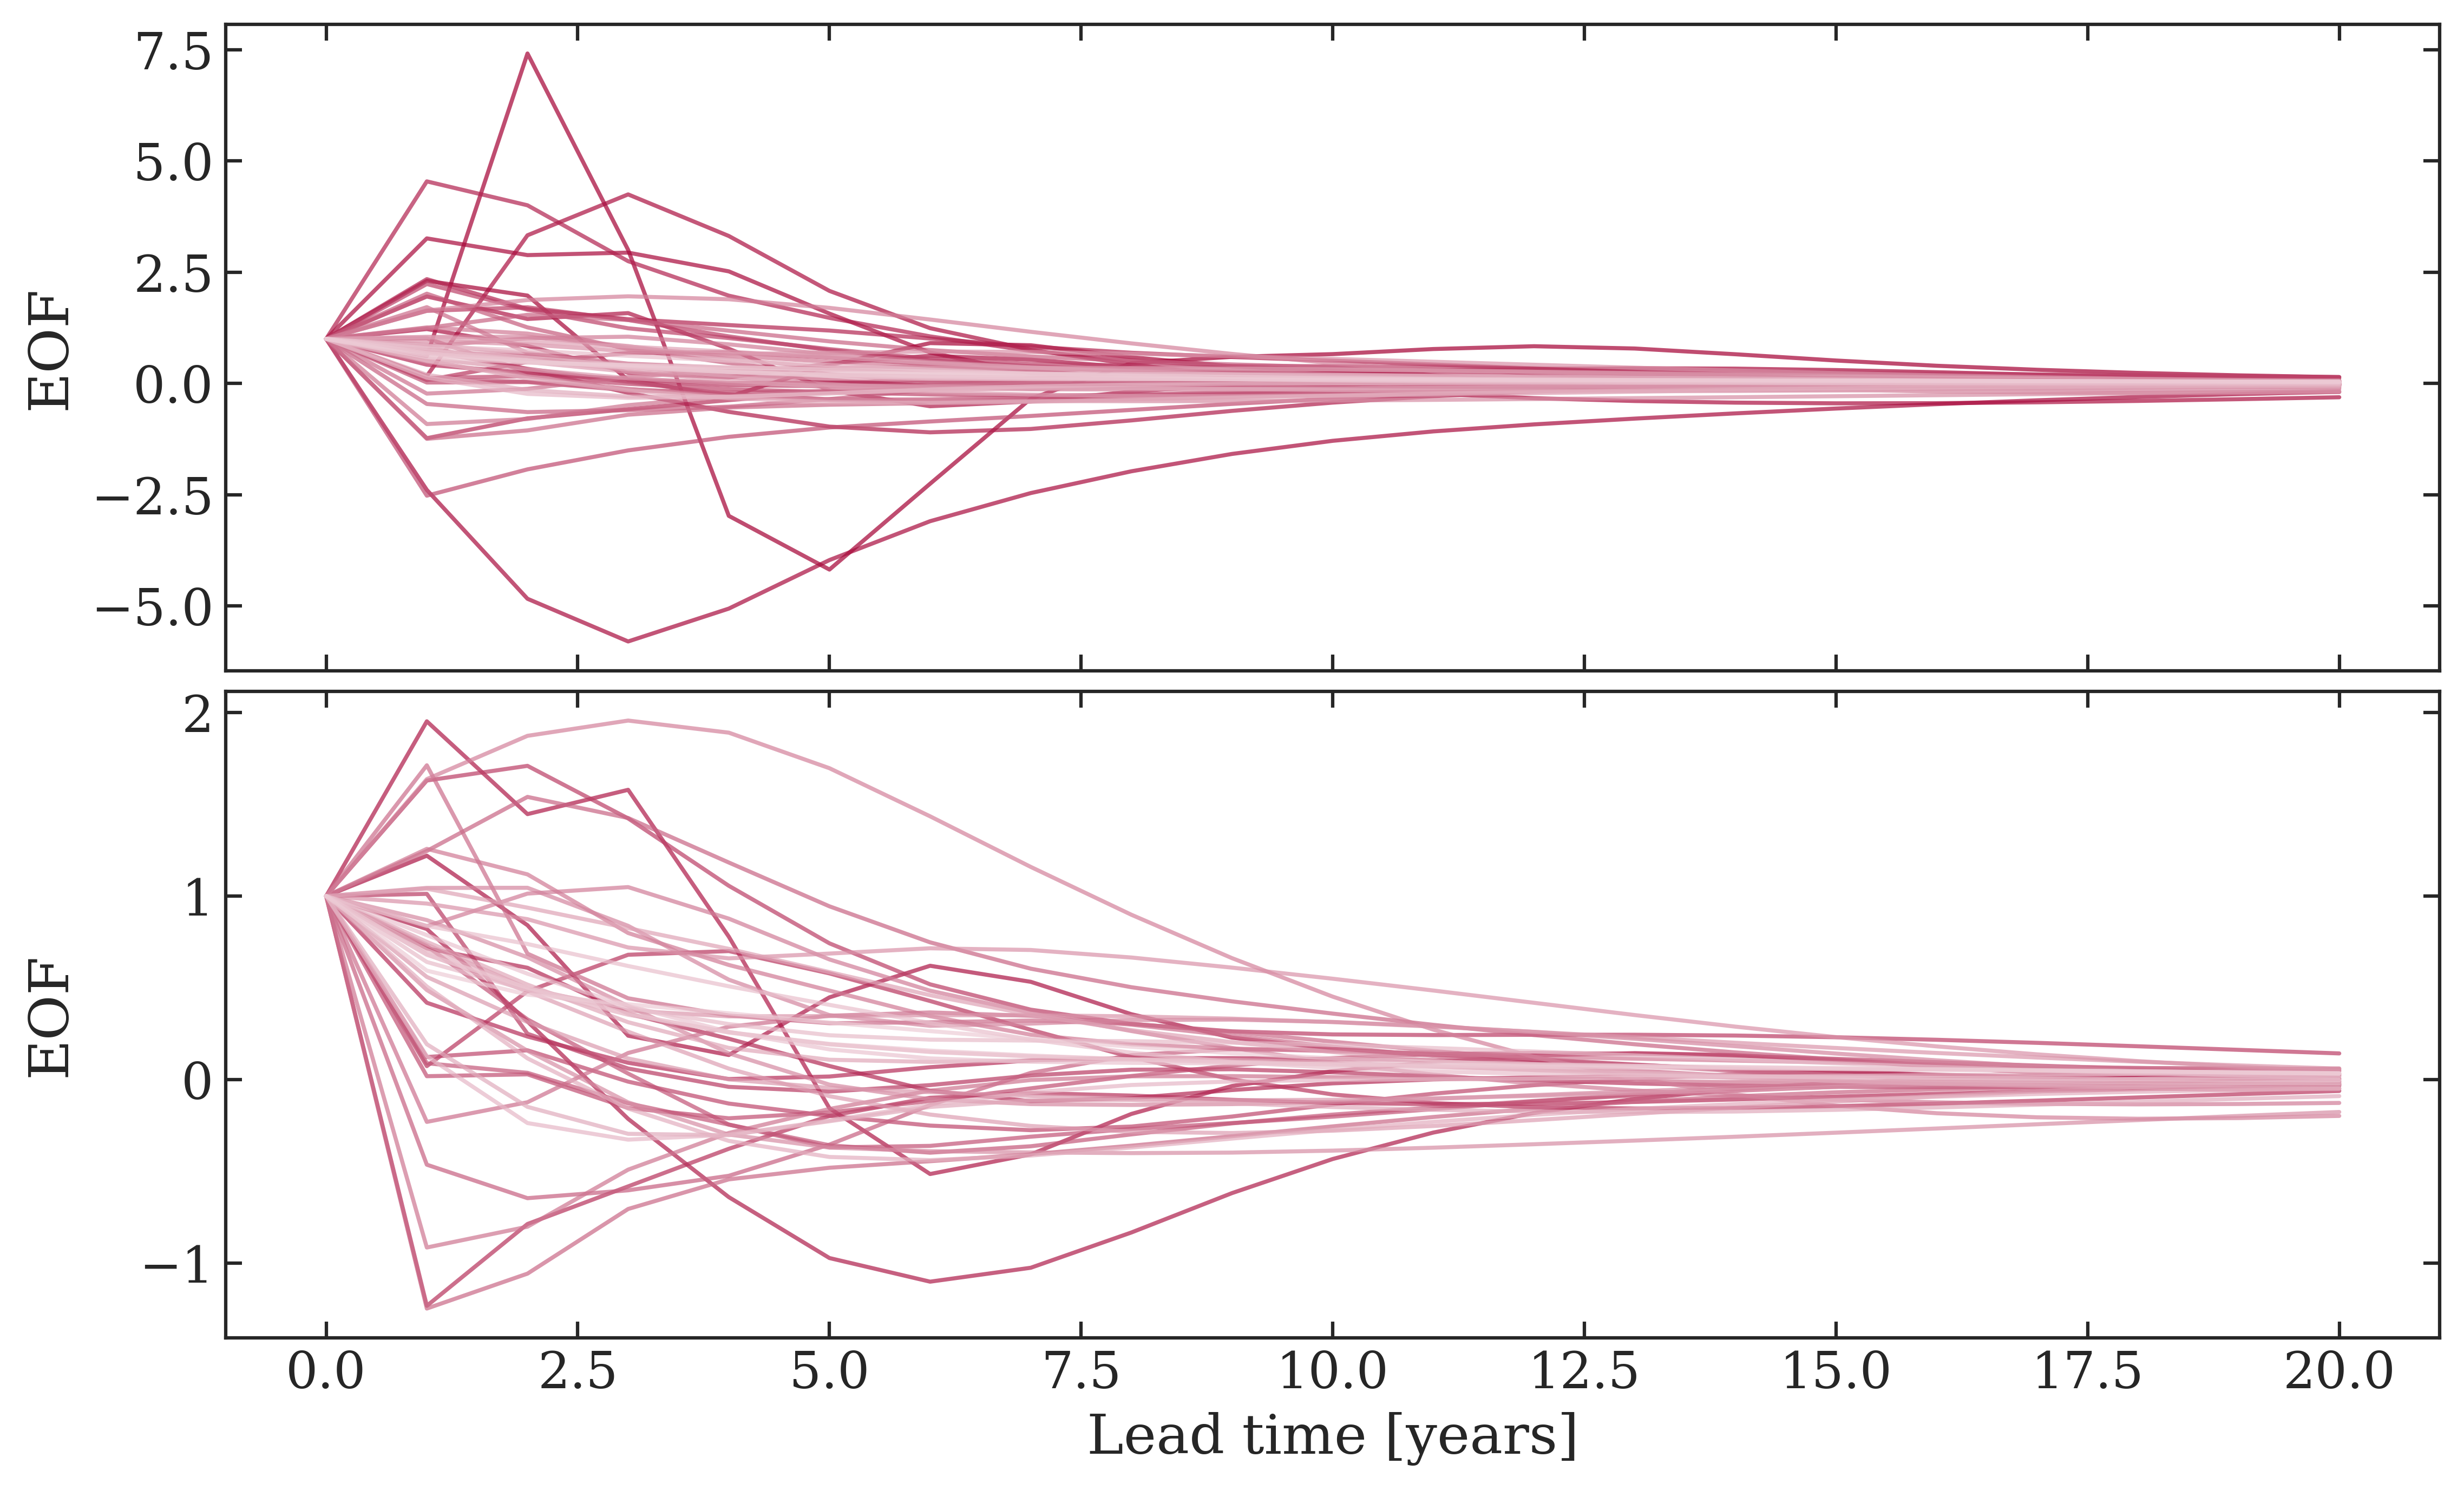

In [25]:
def plot_forecast_eof(n_steps=15):
    ones = xr.DataArray(dask.array.ones(50), coords=dict(state=data.state))
    fc_eof = lim.forecast(ones, n_steps, data.isel(time=0).time.item())
    # fc_eof = lim.forecast(data.isel(time=0), n_steps, data.isel(time=0).time.item())

    fig, axs = plt.subplots(2, sharex=True, figsize=(10, 6))
    
    cmap = mpl.colors.LinearSegmentedColormap.from_list("cmap", [
            mpl.colors.to_rgb("white"),
            mpl.colors.to_rgb("C1"),
    ])(np.linspace(1, 0.2, len(fc_eof.state)))

    for state, color in zip(fc_eof.state, cmap):
        y = fc_eof.isel(state=state)
        axs[0].plot(y, color=color, alpha=0.7)
        if np.max(np.abs(y)) < 2:
            axs[1].plot(y, color=color, alpha=0.7)
    
    axs[1].set_xlabel("Lead time [years]")
    axs[0].set_ylabel("EOF")
    axs[1].set_ylabel("EOF")
    # axs[1].set_ylim([-3, 3])
    
    format_plot()

plot_forecast_eof(20)

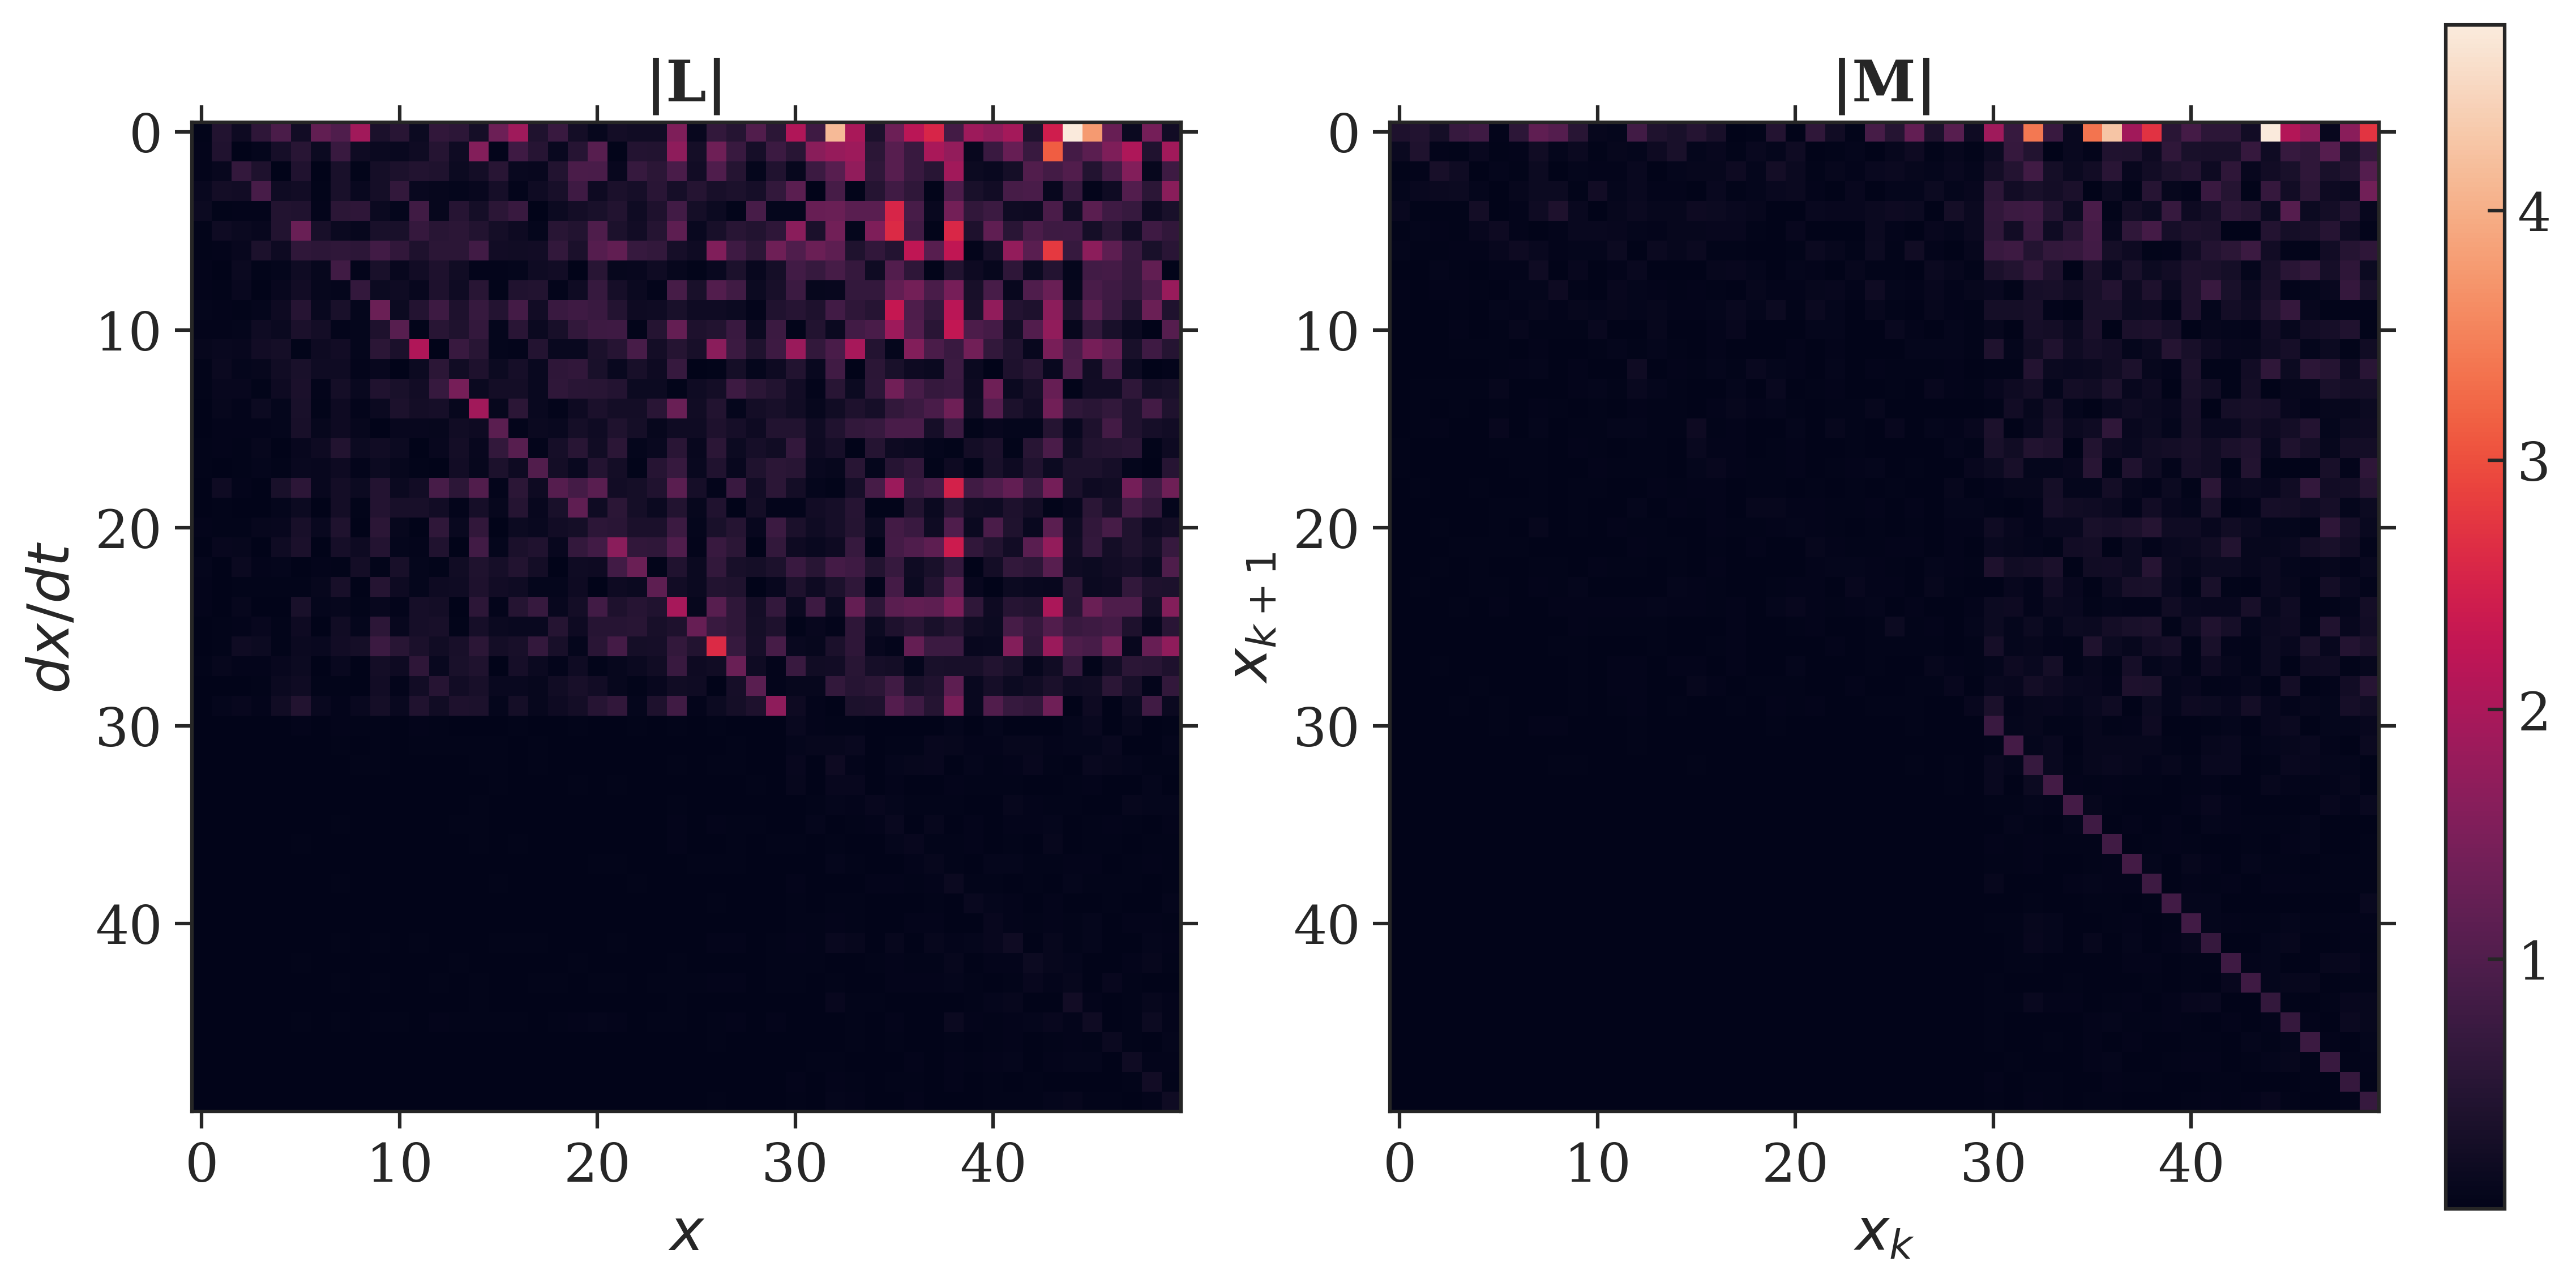

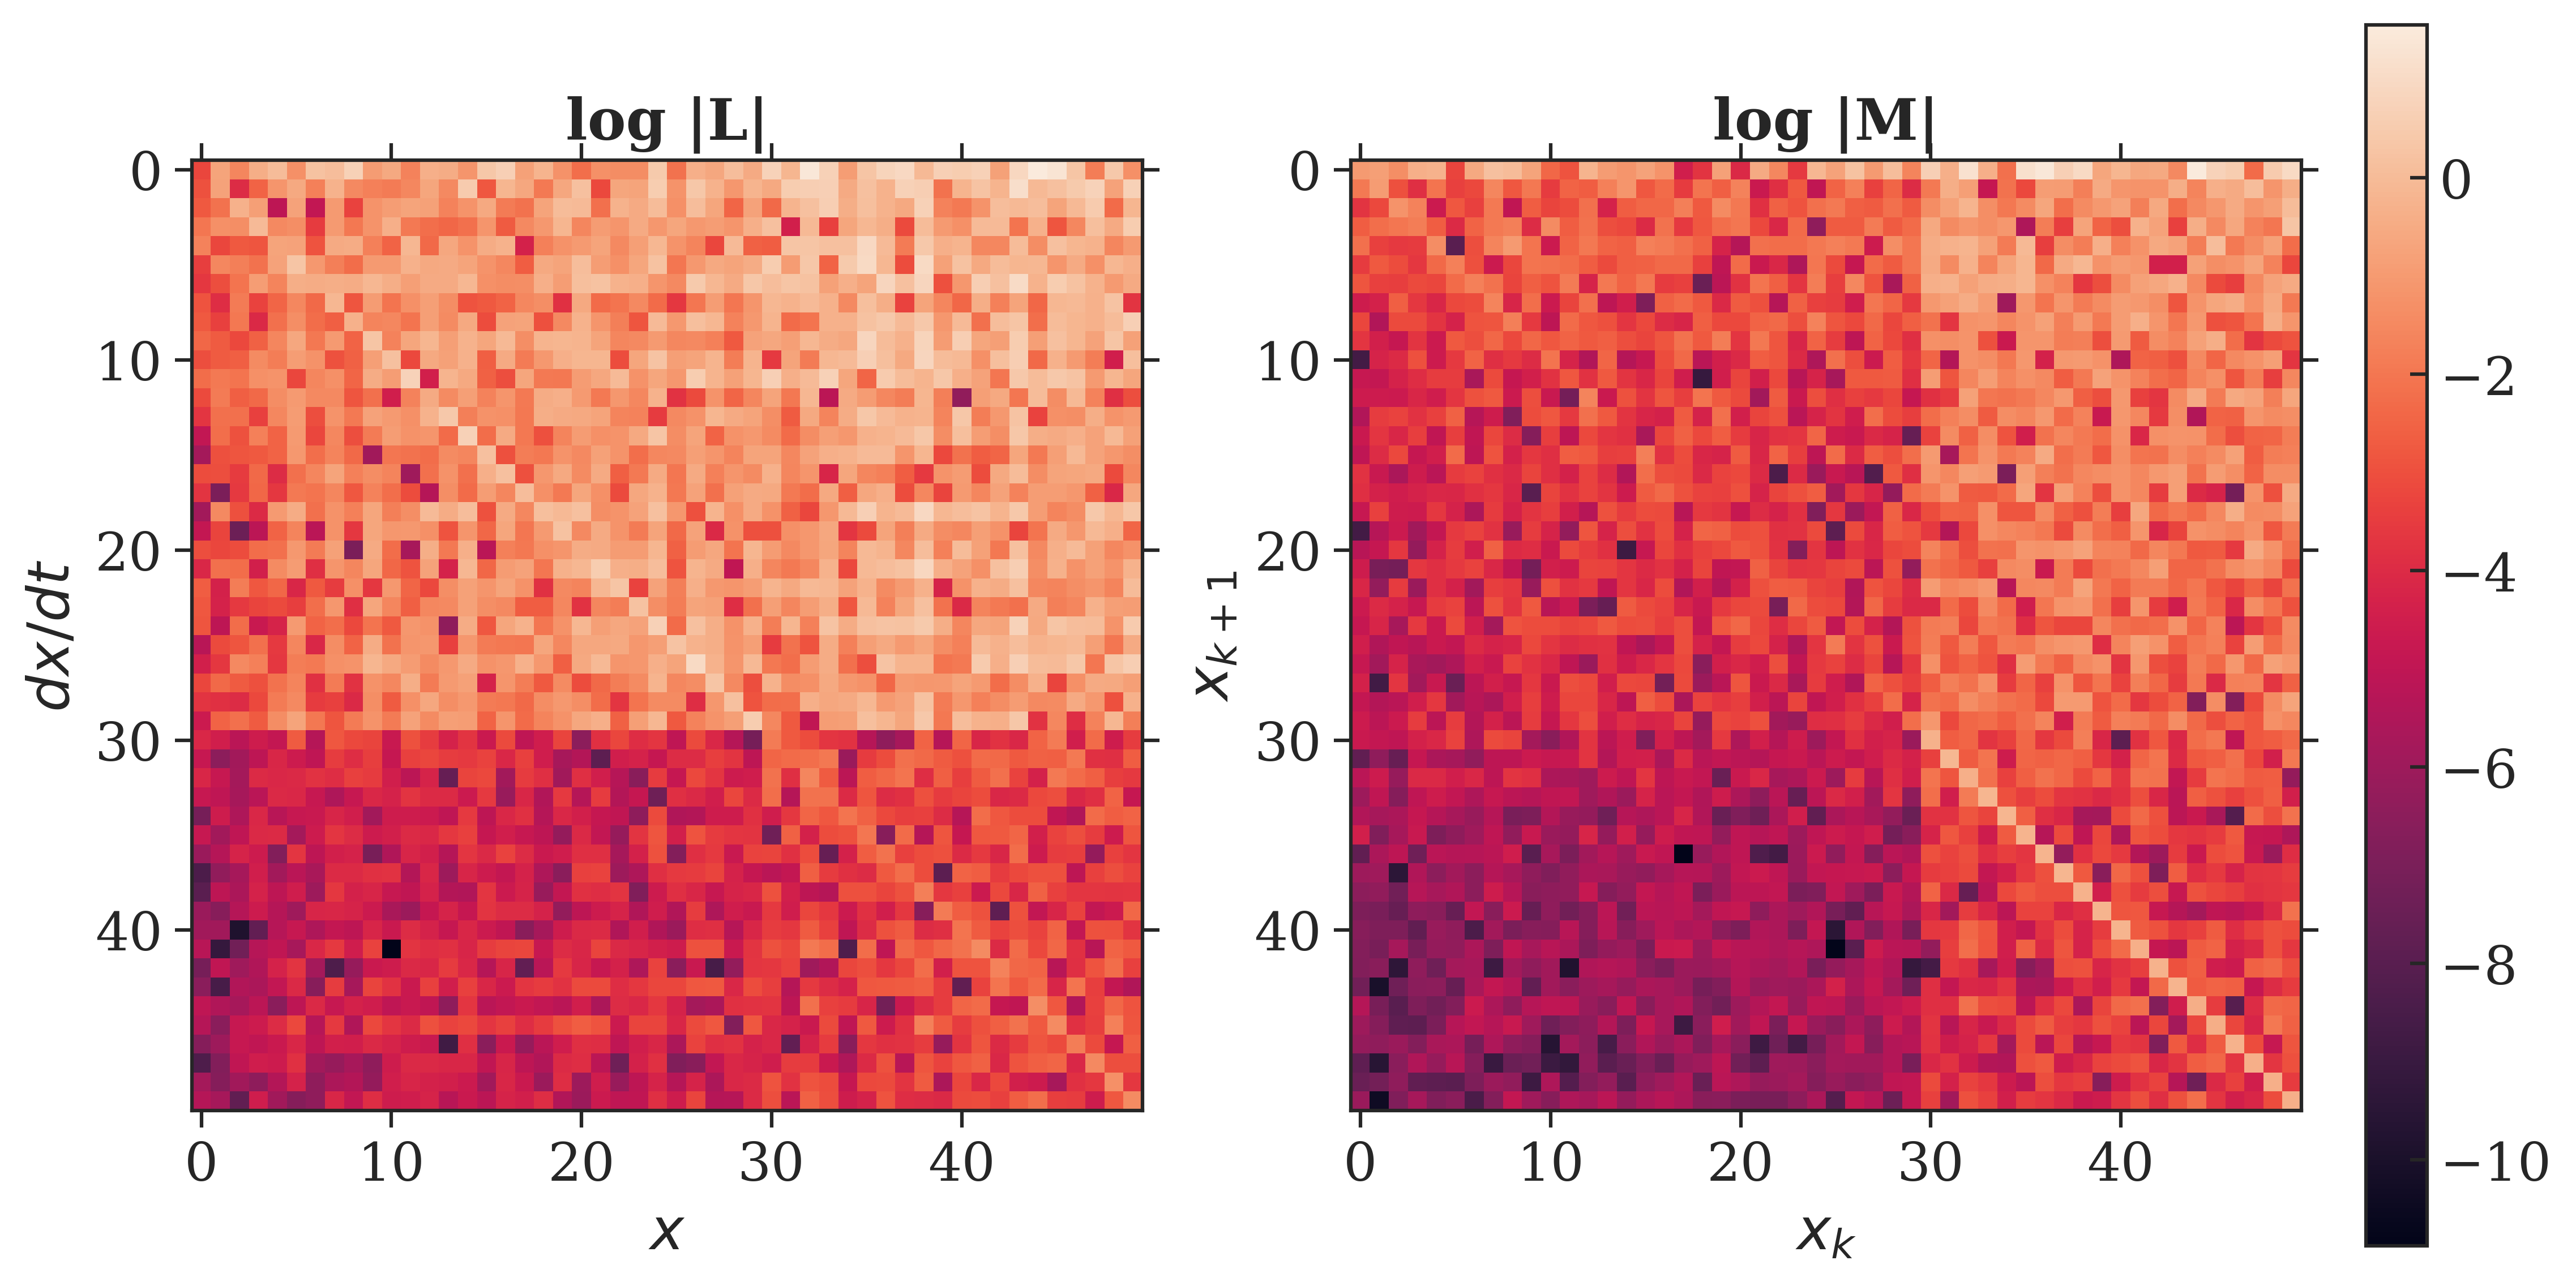

In [10]:
def plot_matrix_values(log=False):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    if log:
        tf = lambda x: np.log(np.abs(x))
        prefix = "log "
    else:
        tf = lambda x: np.abs(x)
        prefix = ""
    
    L = tf(lim.L)
    L /= L.max()
    M = tf(lim.G_tau0)
    M /= M.max()

    ax = axs[0]
    ax.imshow(tf(lim.L))
    ax.set_title(prefix + "|L|")
    ax.set_xlabel("$x$")
    ax.set_ylabel("$dx/dt$")
    ax.tick_params(direction="out")

    ax = axs[1]
    im = ax.imshow(tf(lim.G_tau0))
    ax.set_title(prefix + "|M|")
    ax.set_xlabel("$x_k$")
    ax.set_ylabel("$x_{k+1}$")
    ax.tick_params(direction="out")
    plt.colorbar(im)

    format_plot()

plot_matrix_values()
plot_matrix_values(True)

In [30]:
# fc_eof = lim.forecast(data.isel(time=0), 1850, data.isel(time=0).time.item())
# fc = mapper.backward(fc_eof.data, fc_eof.time, retrend=False)
# fc
# save_mfdataset(fc, Path("/home/enkf6/dstiller/enspred/forecast_anomaly"))

100%|██████████| 1850/1850 [00:00<00:00, 32014.95it/s]
2023-12-08 00:21:58    INFO PhysicalSpaceForecastSpaceMapper.backward()
2023-12-08 00:21:58    INFO Splitting direct fields for ohc700
2023-12-08 00:21:58    INFO Back-projecting joint EOF for zg500, psl, tos, sos, pr, rlut, rsut, tas, zos
2023-12-08 00:21:58    INFO De-standardizing ohc700 after individual EOF
2023-12-08 00:21:58    INFO Back-projecting EOF for ohc700 [1/10]
2023-12-08 00:21:58    INFO Back-projecting EOF for pr [2/10]
2023-12-08 00:21:58    INFO De-standardizing psl after individual EOF
2023-12-08 00:21:58    INFO Back-projecting EOF for psl [3/10]
2023-12-08 00:21:58    INFO De-standardizing rlut after individual EOF
2023-12-08 00:21:58    INFO Back-projecting EOF for rlut [4/10]
2023-12-08 00:21:58    INFO De-standardizing rsut after individual EOF
2023-12-08 00:21:58    INFO Back-projecting EOF for rsut [5/10]
2023-12-08 00:21:59    INFO De-standardizing sos after individual EOF
2023-12-08 00:21:59    INFO Bac